# Maps



In [ ]:
#setup notebook
%config InlineBackend.print_figure_kwargs = {'bbox_inches':'tight'}
from __future__ import annotations
%load_ext autoreload
%autoreload 2

In [ ]:
import xarray as xr
import figanos.matplotlib as fg
import cartopy.crs as ccrs
from matplotlib import pyplot as plt
import numpy as np

fg.utils.set_mpl_style('ouranos')

# load dataset
url = 'https://pavics.ouranos.ca//twitcher/ows/proxy/thredds/dodsC/birdhouse/disk2/cccs_portal/indices/Final/BCCAQv2_CMIP6/tx_max/YS/ssp585/ensemble_percentiles/tx_max_ann_BCCAQ2v2+ANUSPLIN300_historical+ssp585_1950-2100_30ymean_percentiles.nc'
opened = xr.open_dataset(url, decode_timedelta=False)
ds_space = opened[['tx_max_p50']].isel(time=0).sel(lat=slice(40,65), lon=slice(-90,-55))

## Gridded Data on Maps

The gridmap function plots gridded data onto maps built using [Cartopy](https://scitools.org.uk/cartopy/docs/latest/) along with xarray plotting functions.

Visit the timeseries notebook to learn the basic functions of figanos. The main arguments of the timeseries() functions are also found in gridmap(), but new ones are introduced to handle map projections and colormap/colorbar options.

By default, the Lambert Conformal conic projection is used for the basemaps. The projection can be changed using the `projection` argument. The available projections [can be found here](https://scitools.org.uk/cartopy/docs/latest/reference/projections.html#cartopy-projections). The `transform` argument should be used to specify the data coordinate system. If a transform is not provided, figanos will look for dimensions named 'lat' and 'lon' or 'rlat' and 'rlon' and return the `ccrs.PlateCaree()` or `ccrs.RotatedPole()` transforms, respectively.

Features can also be added to the map by passing the names of the [cartopy pre-defined features](https://scitools.org.uk/cartopy/docs/v0.14/matplotlib/feature_interface.html) in a list via the `features` argument (case-insensitively). A nested dictionary can also be passed to `features` in order to apply modifiers to these features, for instance `features = {'coastline': {'scale': '50m', 'color':'grey'}}`.

The gridmap() function only accepts one object in its `data` argument, inside a dictionary or not. Datasets are accepted, but only their first variable will be plotted.

In [ ]:
fg.gridmap(ds_space, features = ['coastline','ocean'], frame = True, show_time = 'lower left')

#plt.savefig("../_static/_images/basic_map.png", bbox_inches='tight')

### Colormaps and colorbars

The colormap used to display the plots with gridmap() is directly dependent on three arguments:

* `cmap` accepts colormap objects or strings. Strings passed can either be names of matplotlib colormaps or names of the IPCC-prescribed colormaps (see cell below). The colormaps are built from RGB data be found in the [IPCC-WG1 Github repository](https://github.com/IPCC-WG1/colormaps). Any colormap specified as a string can be reversed by adding '_r' to the end of the string.

* `divergent` dictates whether or not the colormap will be sequential or divergent. If a number (integer of float) is provided, it becomes the center of the colormap. The default central value is 0.

* `levels=N` will create a discrete colormap of N levels. Otherwise, the colormap will be continuous.

 By default ( if `cmap=None`), figanos will look for certain variable names in the attributes of the DataArray (`da.name` and `da.history`, in this order) and return a colormap corresponding to the 'group' of this variable, following the [IPCC visual style guide's scheme](https://www.ipcc.ch/site/assets/uploads/2022/09/IPCC_AR6_WGI_VisualStyleGuide_2022.pdf) (see page 11). The groups are displayed in the table below.

|Variable Group|Matching strings|
|:------------:|:--------------:|
| Temperature (temp)        | _tas, tasmin, tasmax, tdps, tg, tn, tx_|
|Precipitation (prec)        |_pr, prc, hurs, huss, rain,<br>precip, precipitation, humidity, evapotranspiration_|
|Wind (wind)        |_sfcWind, ua, uas, vas_|
|Cryosphere (cryo)        |_snw, snd, prsn, siconc, ice_|

Note: The strings shown above will not be recognized as variables if they are part of a longer word, for example 'tas' in 'fantastic'.

 When none of the variables names match a group, or when multiple matches are found, the function resorts to the ['Batlow' colormap](https://www.fabiocrameri.ch/batlow/).




In [ ]:
from figanos import data
import json
from pathlib import Path
import matplotlib
with data().joinpath("ipcc_colors").joinpath("variable_groups.json").open(encoding="utf-8") as f:
    var_dict = json.load(f)

for f in sorted(data().joinpath("ipcc_colors/continuous_colormaps_rgb_0-255").glob("*")):
    name=Path(f).name.replace('.txt','')
    cmap = fg.utils.create_cmap(filename=name)
    fig = plt.figure()
    ax = fig.add_axes([0.05, 0.80, 0.9, 0.1])
    cb = matplotlib.colorbar.ColorbarBase(ax, orientation='horizontal',
                                   cmap=cmap)
    cb.outline.set_visible(False)
    cb.ax.set_xticklabels([]);
    split=name.split("_")
    var = split[0]+(split[2] if len(split)==3 else '')
    kw= [k for k,v in var_dict.items() if v ==var]
    #plt.title(f"name: {name} \n keywords: {kw}", wrap=True)
    plt.figtext(.5,.95 + (0.04 *int(len(kw)/10)),f"name: {name}", fontsize=15, ha='center')
    plt.figtext(.5,.91,f"keywords: {kw}",fontsize=10,ha='center', wrap=True)

In [ ]:
# Change the name of our DataArray for one that includes 'pr' (precipitation) - this is still the same temperature data
da_pr = ds_space.tx_max_p50.copy()
da_pr.name = 'pr_max_p50'

# Create a diverging colormap with 8 levels, centered at 300
ax = fg.gridmap(da_pr, divergent=300, levels=8, plot_kw={'cbar_kwargs':{'label':'precipitation'}})
ax.set_title('This is still temperature data,\nbut let\'s pretend.')

**Note**: Using the `levels` argument will result in a colormap that is split evenly across the span of the data, without consideration for how 'nice' the intervals are (i.e. the boundaries of the different colors will often fall on numbers with some decimals, that might be totally significant to an audience). To obtain 'nice' intervals, it is possible to use the `levels` argument in `plot_kw`. This might however, and often, result in the number of levels not being exactly the one that is specified. Using both arguments is not recommended.

In [ ]:
# Create the same map, with 'nice' levels.
ax = fg.gridmap(da_pr,divergent=300,
                plot_kw={'levels':8, 'cbar_kwargs':{'label':None}}, show_time=(0.85, 0.8))
ax.set_title('This cmap has 6 levels instead of 8,\nbut aren\'t they nice?')

It is also possible to specify your own levels by passing a list to `plot_kw['levels'].

In [ ]:
ax = fg.plot.gridmap(da_pr, plot_kw={'levels':[290,294,298,302], 'cbar_kwargs':{'label':None}})
ax.set_title('Custom levels')
fg.utils.plot_logo(ax, loc=(0, 0.85), **{'zoom': 0.08})

In [ ]:
# Create a custom colour map (refer to https://matplotlib.org/stable/tutorials/colors/colormap-manipulation.html#directly-creating-a-segmented-colormap-from-a-list)
from matplotlib.colors import LinearSegmentedColormap
custom_colors =["darkorange", "gold", "lawngreen", "lightseagreen"]
custom_cmap = LinearSegmentedColormap.from_list("mycmap", custom_colors)
ax = fg.gridmap(da_pr, divergent=300, cmap=custom_cmap,
                plot_kw={'levels':8, 'cbar_kwargs':{'label':None}}, show_time=(0.85, 0.8))
ax.set_title('Custom cmap')

### pcolormesh vs contourf

By default, xarray plots two-dimensional DataArrays using the matplotlib pcolormesh function (see [xarray.plot.pcolormesh](https://docs.xarray.dev/en/stable/generated/xarray.plot.pcolormesh.html#xarray.plot.pcolormesh)). The `contourf` argument in gridmap allows the user to use [xarray.plot.contourf](https://docs.xarray.dev/en/stable/generated/xarray.plot.contourf.html?highlight=xarray.plot.contourf) function instead. This also implies the key-value pairs passed in `plot_kw` are passed to these functions.

At a large scales, both of these functions create practically equivalent plots. However, their inner workings are inheritely different, and these different ways of plotting data become apparent at small scales.

When using contourf, passing a value in `levels` is equivalent to passing it in `plot_kw['levels']`, meaning the number of levels on the plot might not be exactly the specified value.

In [ ]:
zoomed = ds_space['tx_max_p50'].sel(lat=slice(44,46), lon=slice(-65,-60))

fig, axs = plt.subplots(1,2, figsize=(10,6), subplot_kw= {'projection': ccrs.LambertConformal()})
fg.gridmap(ax = axs[0], data=zoomed, contourf=False,plot_kw={'levels':10, 'add_colorbar':False})
axs[0].set_title('pcolormesh')
fg.gridmap(ax = axs[1],data=zoomed, contourf=True, plot_kw={'levels':10, 'cbar_kwargs':{'shrink':0.5, 'label':None}})
axs[1].set_title('contourf')

## Station Data on Maps

Data that is georeferenced by coordinates (e.g. latitude and longitude) but is not on a grid can be plotted using the scattermap function. This function is practically identical to `gridmap()`, but introduces some new arguments (see examples below). The function essentially builds a basemap using cartopy and calls `plt.scatter()` to plot the data.

In [ ]:
# Create a fictional observational dataset from scratch
names = ['station_' + str(i) for i in np.arange(10)]
lat = 45 + np.random.rand(10)*3
lon = np.linspace(-76,-70, 10)
tas = 20 + np.random.rand(10)*7
tas[9] = np.nan
yrs = (10+30 * np.random.rand(10))
yrs[0] = np.nan

attrs = {'units': 'degC', 'standard_name': 'air_temperature', 'long_name': 'Near-Surface Daily Maximum Air Temperature'}

tas = xr.DataArray(data=tas,
                   coords={
                       'station': names,
                       'lat':('station', lat),
                       'lon': ('station', lon),
                       'years': ('station', yrs),
                   },
                        dims=['station'],
                        attrs=attrs)
tas.name = 'tas'
tas = tas.to_dataset()
tas.attrs["description"] = "Observations"

# Set nice features
features = {"land": {"color": "#f0f0f0"},
            "rivers": {"edgecolor": "#cfd3d4"},
            "lakes": {"facecolor": "#cfd3d4"},
            "coastline": {"edgecolor": "black"},
}

# Plot
#fig, ax = plt.subplots(subplot_kw={"projection": ccrs.LambertConformal()})
ax =fg.scattermap(tas,
                  sizes ='years',
                  size_range=(15, 100),
                  divergent=23.5,
                features=features,
                   plot_kw={"edgecolor": "black",},
                  fig_kw={'figsize': (9,6)},
                  legend_kw={'loc': 'lower left',
                            'title': 'Number of years of data'},
                 )

#plt.savefig("../_static/_images/station_map.png", bbox_inches='tight')

It is possible to plot observations on top of gridded data by calling both `gridmap()` and `scattermap()` and fixing the colormap limits (`vmin` and `vmax`), like demonstrated below.

In [ ]:
# defining our limits
vmin= 20
vmax= 35

# plotting the gridded data
ax = fg.gridmap(ds_space-273.15,
                plot_kw={'vmin': vmin, 'vmax': vmax, 'add_colorbar': False},
                features=['coastline','ocean'],
                show_time='lower right'
               )
ax.set_extent([-76.5, -69, 44.5, 52], crs=ccrs.PlateCarree()) # equivalent to set_xlim and set_ylim for projections

# plotting the observations
fg.scattermap(tas,
              ax=ax,
              transform=ccrs.PlateCarree(),
              plot_kw={'vmin': vmin,
                       'vmax': vmax,
                       'edgecolor':'grey'}
             )


#plt.savefig("../_static/_images/station+grid_map.png", bbox_inches='tight')

## Hatching on Maps
The hatchmap function plots hatches on top of a map. It is a thin wrap around the [plt.contourf()](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.contourf.html) function, with very similar functionality to `gridmap()` and similar data arguments to `timeseries()`. It can be overlayed on top of a map created with `gridmap()` as shown below. hatchmap can also be used with [plt.contourf()](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.contourf.html) levels in plot_kw.

In [ ]:
# from xclim import ensembles
# import xscen as xs
# urls = ['https://pavics.ouranos.ca/twitcher/ows/proxy/thredds/dodsC/birdhouse/ouranos/portraits-clim-1.1/NorESM1-M_rcp85_prcptot_monthly.nc',
#         'https://pavics.ouranos.ca/twitcher/ows/proxy/thredds/dodsC/birdhouse/ouranos/portraits-clim-1.1/MPI-ESM-LR_rcp85_prcptot_monthly.nc',
#         'https://pavics.ouranos.ca/twitcher/ows/proxy/thredds/dodsC/birdhouse/ouranos/portraits-clim-1.1/IPSL-CM5B-LR_rcp85_prcptot_monthly.nc',
#         ]
# ens = ensembles.create_ensemble(urls)
# fut = ens.sel(time=slice("2020", "2050")).prcptot
# ref = ens.sel(time=slice("1990", "2020")).prcptot
# chng_f= ensembles.robustness_fractions(
#     fut, ref, test="threshold", abs_thresh=2
# ).changed
# sup_8 = chng_f.where(chng_f>0.8).to_dataset()
# inf_5 = chng_f.where(chng_f<0.5).to_dataset()

# ens_stats = ensembles.ensemble_mean_std_max_min(ens)

# out=ens_stats.prcptot_mean.mean(dim='time', keep_attrs='True').to_dataset()
# xs.save_to_netcdf(out, '../../src/figanos/data/test_data/hatchmap-ens_stats.nc')
# xs.save_to_netcdf(sup_8, '../../src/figanos/data/test_data/hatchmap-sup_8.nc')
# xs.save_to_netcdf(inf_5, '../../src/figanos/data/test_data/hatchmap-inf_5.nc')

/home/tjs/git/figanos/src/figanos/matplotlib/utils.py:871: UserWarning: Colormap warning: More than one variable group found. Use the cmap argument.
  warnings.warn(
/home/tjs/mambaforge/envs/figanos/lib/python3.11/site-packages/cartopy/mpl/geoaxes.py:1642: UserWarning: The following kwargs were not used by contour: 'Over 0.8'
  result = super().contourf(*args, **kwargs)


Text(0.5, 1.0, 'Ensemble plot - hatchmap and gridmap')

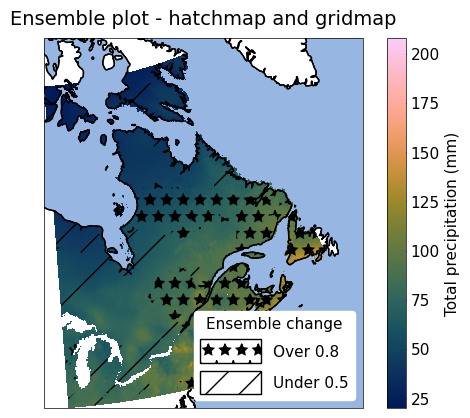

In [ ]:
from figanos import pitou

p = pitou()
ens_stats = xr.open_dataset(p.fetch('hatchmap-ens_stats.nc')).prcptot_mean
sup_8 = xr.open_dataset(p.fetch('hatchmap-sup_8.nc')).changed
inf_5 = xr.open_dataset(p.fetch('hatchmap-inf_5.nc')).changed

ax = fg.gridmap(ens_stats, features = ['coastline','ocean'], frame = True)

fg.hatchmap({'Over 0.8': sup_8, 'Under 0.5': inf_5}, ax=ax,
            plot_kw={'Over 0.8': {'hatches': '*'}},
            features = ['coastline','ocean'], frame = True,
            legend_kw={'title': 'Ensemble change'})
ax.set_title('Ensemble plot - hatchmap and gridmap')

#plt.savefig("../_static/_images/hatch_map.png", bbox_inches='tight')

## GeoDataFrame on Maps

The gdfmap function plots geometries contained in a GeoPandas [GeoDataFrame](https://geopandas.org/en/stable/docs/user_guide/data_structures.html#geodataframe) on maps. It is a thin wrap around the [GeoDataFrame.plot()](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoDataFrame.plot.html#geopandas.GeoDataFrame.plot) method, with verys similar functionality to `gridmap()` and most of the same features.

To use this function, the data to be linked to the colormap has to be included in the GeoDataFrame. Its name (as a string) must be passed to the `df_col` argument. Like described above, if the `cmap` argument is `None`, the function will look for common variable names in the name of this column, and use an appropriate colormap if a match is found.

In [ ]:
import geopandas as gpd
qc_bound = gpd.read_file("https://pavics.ouranos.ca/geoserver/public/ows?service=WFS&version=1.0.0&request=GetFeature&typeName=public%3Aquebec_admin_boundaries&maxFeatures=50&outputFormat=application%2Fjson")
qc_bound['pr']=qc_bound['RES_CO_REG'].astype(float) # create fake precipitation data

ax = fg.gdfmap(qc_bound,
          'pr',
          levels = 16,
          plot_kw = {'legend_kwds': {'label': 'Fake precipitation (fake units)'}}
                )

#plt.savefig("../_static/_images/gdf_map.png", bbox_inches='tight')

Projections can be used like in `gridmap()`, although some of the Cartopy projections might lead to unexpected results due to the interaction between Cartopy and GeoPandas, especially when the whole globe is plotted.

Also note that the colorbar parameters have to be accessed through the `legend_kwds` argument of [GeoDataFrame.plot()](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoDataFrame.plot.html#geopandas.GeoDataFrame.plot).

In [ ]:
r=gpd.read_file('https://www.donneesquebec.ca/recherche/dataset/11a317d0-97a2-4896-85b5-4cb26ccf5dc6/resource/4c6fe152-8c82-4d36-a8e0-9b584b9cde18/download/cours-eau-v3r.json')
ax = fg.gdfmap(r,
               'OBJECTID',
               cmap = 'cool',
               projection = ccrs.Mercator(),
               features = {'ocean': {'color':'#a2bdeb'}},
               plot_kw = {'legend_kwds':{'orientation': 'vertical'}},
               frame=True
              )
ax.set_title("Waterways of Trois-Rivières")

#plt.savefig("../_static/_images/gdf2_map.png", bbox_inches='tight')